# Artificial Intelligence of Things - Demonstration

This document describes methods and mechanisms for the execution of
Artificial Neural Networks in devices with low computational power.

## Dataset
### Load the Yaleface dataset

In [10]:
import src.dataset.yalefaces as yalefaces
import numpy as np

np.random.seed(99)

In [11]:
import numpy as np
X, y = yalefaces.load("data/yalefaces", flatten=True)
X = X.astype("float32") / 255.0

print(f"Loaded {int(X.shape[0]/len(np.unique(y)))} faces from {len(np.unique(y))} individuals,"
f" a total of {X.shape[0]} images of size {yalefaces.SHAPE} ({X[0].shape[0]} pixels).")

Loaded 11 faces from 15 individuals, a total of 165 images of size (243, 320) (77760 pixels).


### Compress faces with Principal Ccomponent Analysis (PCA)

In [12]:
from sklearn.decomposition import PCA

num_faces, num_pixels = X.shape
num_principal_components = int(num_faces)

pca = PCA(n_components=num_principal_components)
pca.fit(X)

print(f"PCA generated {num_principal_components} eigenfaces of size {yalefaces.SHAPE}.")

PCA generated 165 eigenfaces of size (243, 320).


In [13]:
X_compressed = pca.transform(X)

## Train MLP
### Use GPU if NVIDIA CUDA is available

In [14]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cpu


### Create train and test datasets

In [15]:
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

X_train_compressed, X_test_compressed, y_train_compressed, y_test_compressed = train_test_split(X_compressed, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

X_train = torch.Tensor(X_train_compressed)
y_train = torch.LongTensor(y_train_compressed)
train_dataset = TensorDataset(X_train, y_train)

X_test = torch.Tensor(X_test_compressed)
y_test = torch.LongTensor(y_test_compressed)
test_dataset = TensorDataset(X_test, y_test)

### Build a Multilayer Perceptron

In [16]:
from src.models.mlp import MLP
import torch.nn as nn

model = MLP(in_dim=165, out_dim=15, hidden_sizes=[96], activation=nn.ReLU)
model = model.to(device)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0001)

In [18]:
import torch.nn.functional as F

def train(model, device, train_loader, optimizer, loss_fn=F.cross_entropy):
    model.train()

    epoch_loss = 0
    n_samples = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        # prepare
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        # compute
        output = model(data)
        loss = loss_fn(output, target)

        # record
        epoch_loss += loss.item()
        n_samples += output.size(0)

        # adjust
        loss.backward()
        optimizer.step()

    return epoch_loss, n_samples

In [19]:
def test(model, device, test_loader):
    with torch.no_grad():
        model.train(False)
        num_correct = 0
        num_samples = 0

        for batch_idx, (x, y) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)

            scores = model.forward(x)
            _, y_out = scores.max(1)
            
            num_correct += (y_out == y).sum()
            num_samples += y_out.size(0)
        
        acc = float(num_correct) / float(num_samples)
    return acc

In [20]:
import numpy as np
from torch.utils.data import DataLoader

train_accs= []
train_losses = []

for epoch in range(200):
    # train
    train_data = DataLoader(train_dataset, batch_size=64, shuffle=True)
    err, n_train_samples = train(model, device, train_data, optimizer)
    loss = float(err)/float(n_train_samples)
    train_losses.append(loss)
    
    # evaluate
    acc = test(model, device, train_data)
    train_accs.append(acc)


### Training loss

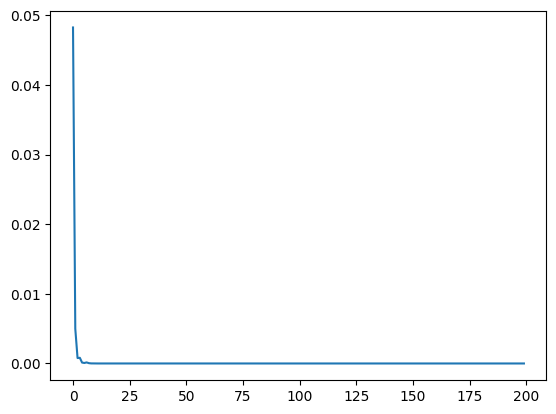

In [21]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses)

### Training accuracy

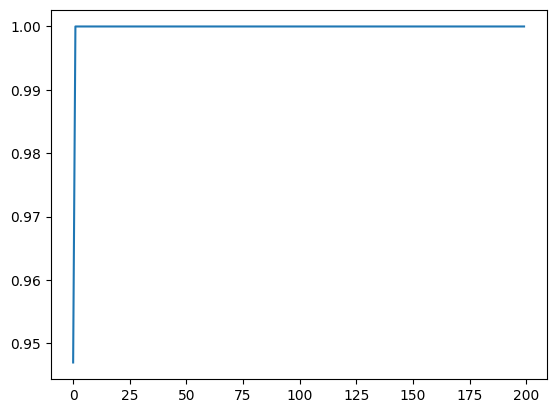

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_accs)

### Test accuracy

In [23]:
test_data = DataLoader(test_dataset, batch_size=len(test_dataset))
acc = test(model, device, test_data)
print(f"Test accuracy: {acc * 100:.2f}")


Test accuracy: 90.91


## Quantize model
### Prepare model for quantization

Recall that our model has the following shape:

```python
model = nn.Sequential(
    nn.Linear(165, 96, bias=True),
    nn.ReLU(),
    nn.Linear(48, 15, bias=False)
)
```

In [24]:
import copy
import torch
from torch import nn

# copy our original model
qmodel_float = copy.deepcopy(model.net)
qmodel_float.eval()

# prepare layers
torch.quantization.fuse_modules(qmodel_float, ['0', '1'], inplace=True)

# add quantization layers for input and output
qmodel_float = nn.Sequential(
    torch.quantization.QuantStub(),
    *qmodel_float,
    torch.quantization.DeQuantStub()
)

### Configure quantization

In [25]:
qmodel_float.qconfig = torch.quantization.default_qconfig
qmodel_float=qmodel_float.to('cpu')

torch.quantization.prepare(qmodel_float, inplace=True)

Sequential(
  (0): QuantStub(
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (1): LinearReLU(
    (0): Linear(in_features=165, out_features=96, bias=False)
    (1): ReLU()
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (2): Identity()
  (3): Linear(
    in_features=96, out_features=15, bias=False
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (4): DeQuantStub()
)

### Quantize network

In [26]:
# learn quantization parameters
with torch.inference_mode():
    for batch_idx, (x, y) in enumerate(test_data):
        x,y = x.to('cpu'), y.to('cpu')
        qmodel_float(x)

# actually quantize weights
qmodel = torch.quantization.convert(qmodel_float, inplace=False)

### Weights size before and after quantization

In [27]:
print("Weight size before quantization:", qmodel_float[1][0].weight.element_size(), "byte(s)")
print("Weight size after quantization:", qmodel[1].weight().element_size(), "byte(s)")

Weight size before quantization: 4 byte(s)
Weight size after quantization: 1 byte(s)


### Accuracy of the quantized model

In [28]:
test_data = DataLoader(test_dataset, batch_size=len(test_dataset))
acc = test(qmodel, 'cpu', test_data)
print(f"Test accuracy: {acc * 100:.2f}")

Test accuracy: 90.91


### Save models and print their sizes in KB

In [29]:
import os
import torch

def print_model_size(mdl, name, filename='tmp.pt'):
    torch.save(mdl.state_dict(), filename)
    print(f"{name}: %.3f KB" %(os.path.getsize(filename)/1e3))

print_model_size(model, "Original ", "mlp.pt")
print_model_size(qmodel, "Quantized", "mlp_quant.pt")

Original : 70.247 KB
Quantized: 20.175 KB


## Export quantized model

### Floating- to fixed-point conversion algorithm

In [30]:
def quant_test():
    scale = 0.390065997838974
    zero_point = 59

    # to be quantized: x
    x = 73.8

    qx = int((x / scale) + zero_point)
    dqx = (qx - zero_point) * scale

    print(f"Original: {x}")
    print(f"Quantized: {qx}")
    print(f"Dequantized: {dqx}")
quant_test()

Original: 73.8
Quantized: 248
Dequantized: 73.72247359156609


### Read weights and quantization parameters

In [31]:
model_params=qmodel_float.state_dict()
qmodel_params = qmodel.state_dict()

In [32]:
def get_weights(model_state_dict, layer_idx):
    if f'{layer_idx}.0.weight' in model_state_dict.keys():
        weights = model_state_dict[f'{layer_idx}.0.weight'].numpy()
    elif f'{layer_idx}.weight' in model_state_dict.keys():
        weights = model_state_dict[f'{layer_idx}.weight'].numpy()
    else:
        raise KeyError(f'{layer_idx}.0.weight or {layer_idx}.weight')
    return weights

def get_scale(qmodel_state_dict, layer_idx):
    w_scale = qmodel_state_dict[f'{layer_idx}._packed_params._packed_params'][0][0].q_scale()
    out_scale = qmodel_state_dict[f'{layer_idx}.scale']
    return w_scale, out_scale.numpy()

def get_zero(qmodel_state_dict, layer_idx):
    w_zero = qmodel_state_dict[f'{layer_idx}._packed_params._packed_params'][0][0].q_zero_point()
    out_zero = qmodel_state_dict[f'{layer_idx}.zero_point']
    return w_zero, out_zero.numpy()

def get_input_qparams(qmodel_state_dict):
    scale = qmodel_state_dict[f'0.scale'][0].numpy()
    zero_point = qmodel_state_dict[f'0.zero_point'][0].numpy()

    return scale, zero_point


### Export quantized weights

In [24]:
import numpy as np

layer_indexes = [1, 3]
with open('src/embedded/esp32s3/src/mlp_params.c', 'w') as source, open('src/embedded/esp32s3/include/mlp_params.h', 'w') as header:
    header.write('#ifndef MLP_PARAMS\n#define MLP_PARAMS\n\n')
    header.write('#include <stdint.h>\n\n')
    
    source.write('#include "mlp_params.h"\n\n')

    x = X_test_compressed[1]
    x_scale, x_zero = get_input_qparams(qmodel_params)
    qx = (np.around(x / x_scale) + x_zero).astype(int)
    
    header.write(f"extern const int8_t input[{len(qx)}];\n")
    header.write(f"extern const float input_zero;\n")
    header.write(f"extern const float input_scale;\n\n")

    source.write(f"const int8_t input[{len(qx)}] = {{")
    for i in range(len(qx)-1):
        source.write(f"{qx[i]}, ")
    source.write(f"{qx[len(qx)-1]}}};\n\n")
    source.write(f"const float input_zero = {x_zero};\n")
    source.write(f"const float input_scale = {x_scale};\n\n")

    for layer in layer_indexes:
        # get raw weights and quantization parameters
        weights = get_weights(model_params, layer).flatten()
        weights_scale, layer_scale = get_scale(qmodel_params, layer)
        weights_zero, layer_zero = get_zero(qmodel_params, layer)
        
        # quantize weights
        qweights = (np.around(weights / weights_scale) + weights_zero).astype(int)
        
        # write weights
        header.write(f"extern const int8_t layer_{layer}_weights[{len(weights)}];\n")

        source.write(f"const int8_t layer_{layer}_weights[{len(qweights)}] = {{")
        for i in range(len(qweights)-1):
            source.write(f"{qweights[i]}, ")
        source.write(f"{qweights[len(qweights)-1]}}};\n\n")

        header.write(f"extern const float layer_{layer}_weights_zero;\n")
        header.write(f"extern const float layer_{layer}_weights_scale;\n\n")

        header.write(f"extern const float layer_{layer}_zero;\n")
        header.write(f"extern const float layer_{layer}_scale;\n\n")

        source.write(f"const float layer_{layer}_weights_zero = {weights_zero};\n")
        source.write(f"const float layer_{layer}_weights_scale = {weights_scale};\n\n")
        
        source.write(f"const float layer_{layer}_zero = {layer_zero};\n")
        source.write(f"const float layer_{layer}_scale = {layer_scale};\n\n")
    header.write('\n#endif // end of MLP_PARAMS\n')

### Export the quantized weights for full-fixed-point arithmetic

In [79]:
import numpy as np

layer_indexes = [1, 3]
input_index = 1

with open('src/embedded/esp32s3/src/mlp_params.c', 'w') as source, open('src/embedded/esp32s3/include/mlp_params.h', 'w') as header:
    header.write('#ifndef MLP_PARAMS\n#define MLP_PARAMS\n\n')
    header.write('#include <stdint.h>\n\n')
    
    source.write('#include "mlp_params.h"\n\n')

    ex = X_test_compressed[input_index]
    ey = y_test_compressed[input_index]
    x_scale, x_zero = get_input_qparams(qmodel_params)
    qx = (np.around(ex / x_scale) + x_zero).astype(int)
    
    header.write(f"extern const int8_t input[{len(qx)}];\n")
    header.write(f"extern const int8_t output;\n")
    header.write(f"extern const int8_t input_zero;\n")
    header.write(f"extern const float input_scale;\n\n")

    source.write(f"const int8_t output = {ey};\n")
    source.write(f"const int8_t input[{len(qx)}] = {{")
    for i in range(len(qx)-1):
        source.write(f"{qx[i]}, ")
    source.write(f"{qx[len(qx)-1]}}};\n\n")
    source.write(f"const int8_t input_zero = {x_zero};\n")
    source.write(f"const float input_scale = {x_scale};\n\n")

    input_scale = x_scale
    for layer in layer_indexes:
        # get raw weights and quantization parameters
        weights = get_weights(model_params, layer).flatten()
        weights_scale, layer_scale = get_scale(qmodel_params, layer)
        weights_zero, layer_zero = get_zero(qmodel_params, layer)

        output_multiplier = (input_scale * weights_scale) / layer_scale
        output_right_shifts = 0
        
        assert output_multiplier > 0.0
        assert output_multiplier < 1.0

        while output_multiplier < 0.5:
            output_multiplier *= 2.0
            output_right_shifts += 1
        
        # if output_multiplier == (1<<31):
        #     output_multiplier /= 2.0
        #     output_right_shifts -= 1
        output_multiplier_fxp = (np.around(output_multiplier * (1<<31))).astype(int)

#         header.write(f"extern const float layer_{layer}_fpmult;\n");
#         source.write(f"const float layer_{layer}_fpmult = {output_multiplier};\n");
        
        header.write(f"#define layer_{layer}_fpmult {output_multiplier}\n");
        
        header.write(f"extern const int32_t layer_{layer}_multiplier;\n");
        header.write(f"extern const int32_t layer_{layer}_rshifts;\n");
        source.write(f"const int32_t layer_{layer}_multiplier = {output_multiplier_fxp};\n");
        source.write(f"const int32_t layer_{layer}_rshifts = {output_right_shifts};\n\n");

        # quantize weights
        qweights = (np.around(weights / weights_scale) + weights_zero).astype(int)

        # write weights
        header.write(f"extern const int8_t layer_{layer}_weights[{len(weights)}];\n")

        source.write(f"const int8_t layer_{layer}_weights[{len(qweights)}] = {{")
        for i in range(len(qweights)-1):
            source.write(f"{qweights[i]}, ")
        source.write(f"{qweights[len(qweights)-1]}}};\n\n")

        header.write(f"extern const int8_t layer_{layer}_weights_zero;\n")
        header.write(f"extern const float layer_{layer}_weights_scale;\n\n")

        header.write(f"extern const int8_t layer_{layer}_zero;\n")
        header.write(f"extern const float layer_{layer}_scale;\n\n")

        source.write(f"const int8_t layer_{layer}_weights_zero = {weights_zero};\n")
        source.write(f"const float layer_{layer}_weights_scale = {weights_scale};\n\n")
        
        source.write(f"const int8_t layer_{layer}_zero = {layer_zero};\n")
        source.write(f"const float layer_{layer}_scale = {layer_scale};\n\n")

        input_scale = layer_scale
    header.write('\n#endif // end of MLP_PARAMS\n')

In [36]:
def quantize_multiplier(multiplier: float):
    assert multiplier > 0.0
    assert multiplier < 1.0

    fxp_scale = 2.0/255.0

    s = 0
    while (multiplier < 0.5):
        multiplier *= 2
        s += 1
    
    fxp = int(round(multiplier * (2^31)))
    return fxp, multiplier, s
print(quantize_multiplier(0.33))

(19, 0.66, 1)


## DEMO with ESP-32-S3

In [81]:
import time
import serial
import struct

with serial.Serial("/dev/ttyUSB0", 921600) as esp32:
    esp32.readlines(1)
    num_correct = 0

    num_tests = len(X_test_compressed)
#     num_tests = 5
    
    for i in range(num_tests):
        subject_features = X_test_compressed[i]
        subject_id = y_test_compressed[i]
        
        x_scale, x_zero = get_input_qparams(qmodel_params)
        qx = (np.around(subject_features / x_scale) + x_zero).astype(int)
        
        qx8 = np.int8(qx)
        y8 = np.int8(subject_id)

        esp32.write(qx8.tobytes())
        esp32.write(y8.tobytes())

        result = esp32.readline()
        cycles = esp32.readline()
        got = int(result, base=10)
        if got == y8:
            num_correct += 1
            status='OK'
        else:
            status='FAIL'


        duration = int(cycles, base=10)
        print(f"{status}\tsent {y8}\tgot {int(result, base=10)}\t{duration/240000:.2f} ms\taccuracy {num_correct/(i+1):.2f}%")
        time.sleep(0.5)
    
    acc = num_correct/num_tests
    print(f"Accuracy: {acc}%")

FAIL	sent 13	got 9	1.82 ms	accuracy 0.00%
FAIL	sent 5	got 2	1.54 ms	accuracy 0.00%
FAIL	sent 10	got 3	1.54 ms	accuracy 0.00%
FAIL	sent 11	got 0	1.54 ms	accuracy 0.00%
FAIL	sent 2	got 4	1.54 ms	accuracy 0.00%
OK	sent 4	got 4	1.54 ms	accuracy 0.17%
FAIL	sent 6	got 8	1.54 ms	accuracy 0.14%
FAIL	sent 5	got 4	1.54 ms	accuracy 0.12%
FAIL	sent 4	got 8	1.54 ms	accuracy 0.11%
FAIL	sent 12	got 13	1.54 ms	accuracy 0.10%
FAIL	sent 10	got 13	1.54 ms	accuracy 0.09%
FAIL	sent 3	got 10	1.54 ms	accuracy 0.08%
OK	sent 7	got 7	1.54 ms	accuracy 0.15%
FAIL	sent 3	got 0	1.54 ms	accuracy 0.14%
FAIL	sent 8	got 14	1.54 ms	accuracy 0.13%
FAIL	sent 2	got 8	1.54 ms	accuracy 0.12%
FAIL	sent 12	got 7	1.54 ms	accuracy 0.12%
FAIL	sent 8	got 11	1.54 ms	accuracy 0.11%
FAIL	sent 9	got 5	1.54 ms	accuracy 0.11%
FAIL	sent 0	got 13	1.54 ms	accuracy 0.10%
FAIL	sent 1	got 14	1.54 ms	accuracy 0.10%
FAIL	sent 3	got 0	1.54 ms	accuracy 0.09%
FAIL	sent 6	got 0	1.54 ms	accuracy 0.09%
FAIL	sent 14	got 11	1.54 ms	accuracy 0.08%
FAIL	

In [27]:
import time
import serial

with serial.Serial("/dev/ttyUSB0", 921600) as esp32:
    # esp32.readlines(1)
    num_correct = 0

    # for i in range(len(X_test_compressed)):
    for i in range(5):
        subject_features = X_test_compressed[i]
        subject_id = y_test_compressed[i]
        
        x_scale, x_zero = get_input_qparams(qmodel_params)
        qx = (np.around(subject_features / x_scale) + x_zero).astype(int)

        qx8 = np.int8(qx)
        y8 = np.int8(subject_id)

        esp32.write(qx8.tobytes())

## Emulating on-device execution

In [49]:
def relu2(x):
    return (abs(x) + x) / 2

def relu(x):
    return (abs(x) + x) / 2

def softmax(x):
    e = np.exp(x)
    return e / e.sum()

for idx in range(10):
    # input layer
    # idx = 1
    x = X_test_compressed[idx]
    y = y_test_compressed[idx]

    x_scale, x_zero = get_input_qparams(qmodel_params)
    qx = (np.around(x / x_scale) + x_zero).astype(int)
    qx = np.int8(qx)

    # hidden layer
    hidden_layer = 1
    M1 = get_weights(model_params, hidden_layer)
    M1_scale, L2_scale = get_scale(qmodel_params, hidden_layer)
    M1_zero, L2_zero = get_zero(qmodel_params, hidden_layer)

    qM1 = (np.around(M1 / M1_scale) + M1_zero).astype(int)
    # qM1 = np.int8(qM1)
    M1_zero = (np.array(M1_zero)).astype(int)
    x_zero = (np.array(x_zero)).astype(int)

    ## Subtracting zero can be avoided with the procedure described in [4].

    qy1 = (qM1 - M1_zero) @ (qx - x_zero)

    ## We are converting the resulting fixed-point vector into floating
    ## point before quantizing it to int8 fixed-point again. This can
    ## be avoided as described in [4] and will be done later.
    l1_outscaler = (np.float32(x_scale) * np.float32(M1_scale)) / np.float32(L2_scale)
    assert l1_outscaler > 0.0
    assert l1_outscaler < 1.0

    l1_rshifts = 0
    while l1_outscaler < 0.5:
        l1_outscaler *= 2.0
        l1_rshifts += 1
    l1_fxp = (np.around(l1_outscaler * (1<<31))).astype(int)

    qy1 = np.int8(((qy1 * l1_fxp) >> l1_rshifts) + L2_zero)


    qy2 = relu(qy1)
    print(qy2)
    qy2 = np.int8(qy2)
    
    assert 1 == 0

    # output layer
    output_layer = 3
    M3 = get_weights(model_params, output_layer)
    M3_scale, L4_scale = get_scale(qmodel_params, output_layer)
    M3_zero, L4_zero = get_zero(qmodel_params, output_layer)

    qM3 = (np.around(M3 / M3_scale) + M3_zero).astype(int)

    qy3 = (qM3 - M3_zero) @ (qy2 - L2_zero)

    l3_multiplier = (L2_scale * M3_scale) / np.float32(L4_scale)
    l3_rshifts = 0
    if l3_multiplier > 0.0 and l3_multiplier < 1.0:
        while l3_multiplier < 0.5:
            l3_multiplier *= 2.0
            l3_rshifts += 1
        l3_multiplier = (np.around(l3_multiplier * (1<<31))).astype(int)
    else:
        print("ERROR calculating L3 multiplier, fallback to floating point arithmetic")
    print(f"Multiplier: {l3_multiplier}, shifts: {l3_rshifts}")
    
    print(type(qy3))
    print(qy3)
    qy3 = (qy3 * l3_multiplier) >> l3_rshifts

    # y3_float = (L2_scale * M3_scale) * qy3

    # y4 = L4_scale * (y3_float - L4_zero)
    # y4 = softmax(y4)

    print(y, np.argmax(qy3))

[  0.   0.   0. -28.  42. -16.   0. -48.  36.   0. -10.   0.  14.  44.
  -2.  28.   0.  -2.   0.   0.  32.   0.   0.   0.   0. -62.  32.   0.
   0.   0.  20.   0.   0.  24.   0.   0.   0. -34.  60.  48.   0.   0.
 -34.   0.  34.  -6. -12.   0.   0.  46. -48.   0.  -8. -44. -38. -52.
   0.   0.   4.   0.   0.  18.   0.  40.  48.  62. -56.  46.   0.   0.
   0.   0.  62.   0.   0.  44.   0.   0.  38. -52. -24. -56. -64.   0.
  56.  32. -64. -38.  -6.   0.   0.  48.   0.   0.   0.   0.]


AssertionError: 

## Platformio config

```
[env:nodemcu-32s2]
platform = espressif32
board = nodemcu-32s2
framework = arduino
board_build.mcu = esp32s3

; change MCU frequency
board_build.f_cpu = 240000000L
monitor_speed = 921600
```